# Inverse distance weighting interpolation

Goal: Extract the weights and apply the IDW method exactly like the Python package, [pyinterp](https://pangeo-pyinterp.readthedocs.io)

In [1]:
import xarray as xr
import numpy as np
import xmitgcm
import sandbox as sb

import matplotlib.pyplot as plt
%matplotlib inline

Given NESBA track ranges

In [2]:
tm4 = [-sb.degMinSec2decimal(70,54.0876), #lon
       sb.degMinSec2decimal(39,50.8542)]  #lat
at  = [-sb.degMinSec2decimal(70,53.1670), 
       sb.degMinSec2decimal(39,57.1500)]
line= sb.gcspace(tm4, at, npts=5)
line

[[-70.90146,
  -70.8976285520652,
  -70.89379418381897,
  -70.8899568903324,
  -70.88611666666667],
 [39.84757, 39.873802868730095, 39.90003549179459, 39.92626786896187, 39.9525]]

# PyInterp Example

Started with the [example](https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/pangeo_unstructured_grid.html) in their documentation. And imagined up a way to calc the weights for an IDW interpolation

## Bunny's manual distance matching
1. find spheroidal points between a source and receiver
2. Load model grid
3. Fill land points as a saftey measure
4. Mask to regional domain of interest
5. make meshgrid of regional lat, lons

6. loop through ihop range points: ihopLine
    a. query points in filled mesh nearest ihop range point
    b. calc distances using vincenty wgs84 from ihop range point to regional points
    c. loop through queried points
        A. loop through measured distances
            i. if measured distance is same as queried distance save lat lon indices.
            
The goal is to save indices with their weights, and implement the same IDW algo in **ihop**

In [3]:
import pyinterp
from pyinterp import tests, fill
from pyinterp.backends import xarray

In [4]:
import cartopy.crs
import cartopy.mpl.ticker

# Fill NaNs and subset DataSet

The interpolation won't work on NaN output, so we exptrapolate using the LOESS algorithm. 

Following [this example](https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/ex_fill_undef.html#gauss-seidel). Feels like a hack, take this interp to compare found indices and weights. Ditch this interp otherwise. 

Subset the xarray DataSet between (39,40)deg N and (-71,-70)degE, this should save some computational time

In [5]:
ds = tests.load_grid2d()
dsNESBA = ds.sel(lat=slice(39, 40), 
                 lon=slice(sb.lon180to360(-71), sb.lon180to360(-70)) )

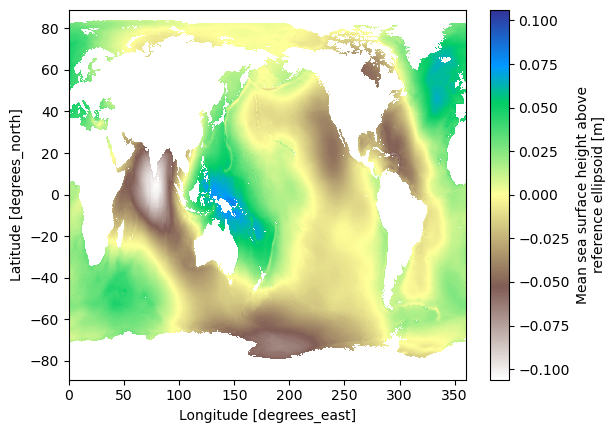

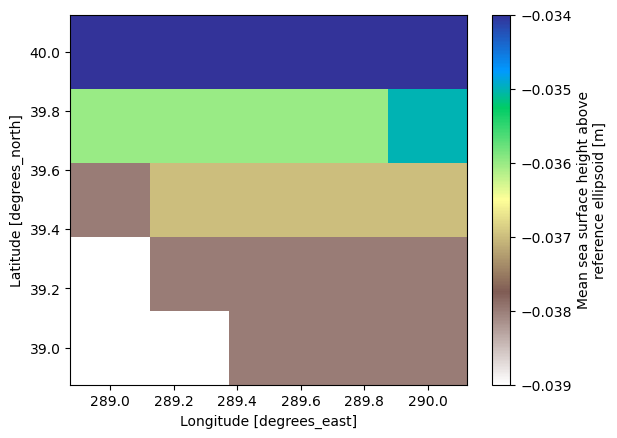

In [6]:
ds.mss.plot(cmap = 'terrain_r')

plt.figure()
dsNESBA.mss.plot(cmap='terrain_r')

### Fill NanNs 🙄

On the full grid, **ds**

In [7]:
grid = pyinterp.backends.xarray.Grid2D(ds.mss)
filled = pyinterp.fill.loess(grid, nx=3, ny=3)

In [8]:
x , y = np.meshgrid(ds.lon, ds.lat)

In [9]:
filled_mesh = pyinterp.RTree()
filled_mesh.packing(np.vstack((x.ravel(), y.ravel())).T, filled.T.ravel())

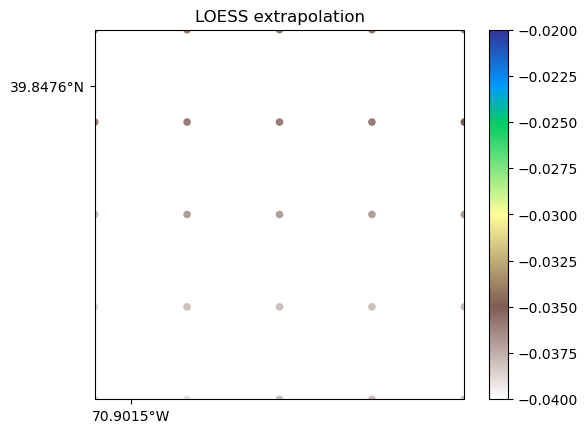

In [10]:
fig = plt.figure()
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
im=ax.scatter(x,
              y,
              c=filled.T,
              cmap='terrain_r',
              s=20,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('LOESS extrapolation')
ax.set_extent([-71, -70, 39, 40])

im.set_clim(-.04, -0.02)
plt.colorbar(im)

## Distances between 2D ihop range points to model grid

for points of **line**

In [11]:
def nearestIndices(ds, k=4):
    # for all points
    TOL = 1e-1
    lonN, latN = np.meshgrid(ds.lon, ds.lat)
    idList = []

    for lon, lat in zip(line[0], line[1]):
        lon = sb.lon180to360(lon)

        lons, lats = np.meshgrid(np.ones(len(ds.lon)) * lon,
                                 np.ones(len(ds.lat)) * lat )

        distquery = filled_mesh.query(np.array([[lon,lat]]), k=k)
        distquery = distquery[0][0]

        distances = pyinterp.geodetic.coordinate_distances( lons.ravel(), lats.ravel(), 
                                                            lonN.ravel(), latN.ravel(),
                                                            strategy='vincenty')
    #    distancesreshaped = distances.reshape(lonN.shape)
        idLat = []; idLon = []
        for dist in distquery:
            for d in range(len(distances)):
                if abs(dist - distances[d]) < TOL:
                    (i,j) = np.unravel_index(d, lonN.shape)
                    idLat.append(i)
                    idLon.append(j)
                    
        idList.append([idLon, idLat, distquery])
    return idList

In [12]:
idList = nearestIndices(dsNESBA)

# Clone of IDW algo in RTree

the RTree is created from the BOOST Library (C++ code) so I'm unsure of the exact details of their implementation

In [13]:
def calc_idw(dist, values):
    ww = sum(1/dist**2)
    u = 0
    for ii in range(len(dist)):
        u = u + values[ii]/dist[ii]**2/ww
    return u

Overwrite distances with IDW weights

In [14]:
for i in range(len(idList)):
    dist = idList[i][2]
    idList[i][2] = 1/dist**2

### idList

output is \[lon index\], \[lat index\], array\[idw weights\]

In [15]:
idList[0]

[[0, 1, 0, 1],
 [3, 3, 4, 4],
 array([5.30272171e-09, 3.50112101e-09, 2.79788574e-09, 2.20215105e-09])]

## Compare to PyInterp IDW

Now, that I have the indices and weights, I should be able to reproduce IDW algo output

In [16]:
def calc_idw_w_weights(ds, idList):
    idLon = idList[0]
    idLat = idList[1]
    weights = idList[2]
    
    u = 0
    for ii in range(len(idLon)):
        u = u + ds.isel(lon=idLon[ii],lat=idLat[ii])*weights[ii]
    return u / sum(weights)

In [17]:
idw_mss, idw_neighbors = filled_mesh.inverse_distance_weighting(
    np.vstack((line[0][0],line[1][0])).T, 
    within = True,
    #radius = 100000, #100 km radius
    k=4
)
idw_mss

array([-0.03527556])

In [18]:
calc_idw_w_weights(dsNESBA, idList[0]).mss - idw_mss[0]

<xarray.DataArray 'mss' ()>
array(-2.08166817e-17)
Coordinates:
    lat      float64 40.0

<sub> Written by Escobar, I. on October 2022 </sub>